# vdp-thal Fourier Coefficients

Get Fourier coefficients for $\mathcal{H}$-functions. To be used to generate two-parameter bifurcation diagrams in XPP.


# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import vdp_thal

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps)

from lib.rhs import _redu_c2, _full

from lib.rhs import _redu_c, _full, rhs_avg_1df
from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined,
                           add_diagram_full, add_diagram_1d,
                           load_diagram_full_f)

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-7,'atol':1e-7,'method':'LSODA'}

In [3]:
pd_thal = {'gL':0.05,'gna':3,'gk':5,
           'gt':5,'eL':-70,'ena':50,
           'ek':-90,'et':0,'esyn':-100,
           'c':1,'alpha':3,'beta':2,
           'sigmat':0.8,'vt':-20,'del':0,
           'ib':8.2,'om':1,'om_fix':1}

pd_vdp = {'mu':.04,'sigmat':0.1,'vt':1,
          'alpha':3,'beta':2,'esyn':-2,
          'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws_thal = {'var_names':['v','h','r','w'],
            'pardict':pd_thal,
            'rhs':vdp_thal.rhs_thal,
            'coupling':vdp_thal.coupling_thal,
            'init':np.array([-.64,0.71,0.25,0,6]),
            'TN':10000,
            'trunc_order':1,
            'z_forward':False,
            'i_forward':False,
            'i_bad_dx':[False,True,False,False,False,False],
            'max_iter':20,
            'rtol':1e-12,
            'atol':1e-12,
            'rel_tol':1e-9,
            'save_fig':True,
            'lc_prominence':.05}

kws_vdp = {'var_names':['v','h','w'],
               'pardict':pd_vdp,
               'rhs':vdp_thal.rhs_vdp,
               'coupling':vdp_thal.coupling_vdp,
               'init':np.array([.32,0.128,0.54,20]),
               'TN':10000,
               'trunc_order':1,
               'z_forward':False,
               'i_forward':False,
               'i_bad_dx':[False,True,False,False,False,False],
               'max_iter':20,
               'rtol':1e-10,
               'atol':1e-10,
               'rel_tol':1e-8,
               'save_fig':True,
               'lc_prominence':.05}

In [5]:
het_coeffs = [1,20]

In [6]:
cos = np.cos
sin = np.sin
exp = np.exp

## Defs

In [7]:
# data_dir = 'xpp_tables/'
# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

In [8]:
# def get_coeffs(a,fn,threshold=10.1):
#     coeffs = np.fft.fft(fn)
    
#     # get coeffs above threshold
#     coeffs_re_all = np.real(coeffs)
#     coeffs_im_all = np.imag(coeffs)
#     nn = np.arange(len(coeffs),dtype='int')
    
#     coeffs_re_bool = (np.abs(coeffs_re_all) > threshold)*(nn<a.NH/2)
#     coeffs_im_bool = (np.abs(coeffs_im_all) > threshold)*(nn<a.NH/2)
    
#     print(coeffs_re_bool.sum(),np.where(coeffs_re_bool>0))
#     print(coeffs_im_bool.sum(),np.where(coeffs_im_bool>0))
    
#     print('re',coeffs_re_all[coeffs_re_bool])
#     print('im',coeffs_im_all[coeffs_im_bool])
    
#     freqs = np.fft.fftfreq(len(coeffs),d=(1/a.NH))
    
#     coeffs_re = coeffs_re_all[coeffs_re_bool]
#     coeffs_im = coeffs_im_all[coeffs_im_bool]
    
#     freqs[coeffs_re_bool]

#     return coeffs_re, coeffs_im, freqs[coeffs_re_bool], freqs[coeffs_im_bool]

# def get_coeffs_hom(a,k,**kwargs):
#     fn = a.system1.h['dat_hom'][k]
#     return get_coeffs(a,fn,**kwargs)

# def get_coeffs_het(a,k,j,**kwargs):
#     """
#     require j <= k
#     """
#     assert(j<=k)
#     fn = a.system1.h['dat_het'][k][j]
#     return get_coeffs(a,fn,**kwargs)
    
# def call_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
#     tot = 0
#     for i,c in enumerate(coeffs_re):
#         if fr[i] == 0:
#             tot += c/a.NH
#         else:
#             tot += 2*c*np.cos(a.x*fr[i])/a.NH
    
#     for i,c in enumerate(coeffs_im):
#         tot += -2*c*np.sin(a.x*fi[i])/a.NH

#     return tot

# def print_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
#     # display copy/paste-able equation
#     eq = ''
#     for i,c in enumerate(coeffs_re):
#         if fr[i] == 0:
#             eq += '{:.4f}'.format(c/a.NH)
#         else:
#             eq += '+2*cos(x*{})*({:.4f})'.format(fr[i],c/a.NH)
    
#     for i,c in enumerate(coeffs_im):
#         eq += '-2*sin(x*{})*({:.4f})'.format(fi[i],c/a.NH)
#         #tot += -2*c*np.sin(x*freqs[coeffs_re_bool][i])/a.NH
#     return eq


## Initialize Response Functions

In [9]:
system1 = rsp(idx=0,model_name='vdp_thal0',**kws_thal)
system2 = rsp(idx=1,model_name='vdp_thal1',**kws_vdp)

mkdir ./data/vdp_thal0/
* Loading LC data...
self.T 6.283185307179586 omfix 1.008401523115462
LC0 ini[-0.10425117  0.22993236  0.09898925  0.40570208]
LC0 fin[-0.10425117  0.22993236  0.09898925  0.40570208]
* Loading monodromy...
eigenvalues [6.9104588e-07 1.0000000e+00 8.5649869e-01 6.9399308e-02]
sorted index [0 3 2 1]
eigenvectors[[ 0.00000000e+00  1.30182800e-05  2.53431584e-03  4.03631700e-01]
 [ 0.00000000e+00  6.59891535e-01 -6.40887202e-01 -3.64902091e-01]
 [ 0.00000000e+00  2.71009561e-03 -2.28685349e-01 -2.29689396e-02]
 [ 1.00000000e+00 -7.51355986e-01  7.32775670e-01  8.38689658e-01]]
g1_init[ 0.00253432 -0.6408872  -0.22868535  0.73277567]
z0_init[ 1.14212327  1.53296971 -4.28346711  0.        ]
i0_init[-0.23544812  0.01818329 -4.42638824 -0.        ]
* Floquet Exponent kappa =-0.0246534970519178
* Sorted Exponents =[-2.25762236e+00 -4.24606032e-01 -2.46534971e-02  1.99928324e-10]
* Loading g symbolic...
* Computing g...
g0 ini[0. 0. 0. 0.]
g0 fin[0. 0. 0. 0.]
g1 ini[ 0.0

**Fourier notes**

Recall: Given the fourier coefficients $c_n$ for $n \in\mathbb{Z}$ and supposing that $c_n = a_n + i b_n$, the real Fourier series is given by,
$$\sum_{n =1}^\infty 2 a_n \cos(n \omega t) - 2 b_n \sin(n \omega t).$$
So I really only need to save the coefficients for positive frequencies and double them. 

Goal: given a function, display a list of coefficients (maybe implement text output to copy/past into XPP)

## Defs

In [10]:
def get_coeffs(data,threshold = 0.1):
    coeffs = np.fft.fft(data)
    
    # get coeffs above threshold
    NH = len(data)
    
    coeffs_re_all = np.real(coeffs)
    coeffs_im_all = np.imag(coeffs)
    nn = np.arange(len(coeffs),dtype='int')
    
    coeffs_re_bool = (np.abs(coeffs_re_all) > threshold)*(nn<NH/2)
    coeffs_im_bool = (np.abs(coeffs_im_all) > threshold)*(nn<NH/2)
    
    freqs = np.fft.fftfreq(len(coeffs),d=(1/a.NH))
    
    coeffs_re = coeffs_re_all[coeffs_re_bool]
    coeffs_im = coeffs_im_all[coeffs_im_bool]
    
    freqs[coeffs_re_bool]

    return coeffs_re, coeffs_im, freqs[coeffs_re_bool], freqs[coeffs_im_bool]

def call_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    tot = 0
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            tot += c/a11.NH
        else:
            tot += 2*c*np.cos(a.x*fr[i])/a.NH
    
    for i,c in enumerate(coeffs_im):
        tot += -2*c*np.sin(a.x*fi[i])/a.NH

    return tot

def print_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    # display copy/paste-able equation
    eq = ''
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            eq += '{:.4f}'.format(c/a11.NH)
        else:
            eq += '+2*cos(x*{})*({:.4f})'.format(fr[i],c/a.NH)
    
    for i,c in enumerate(coeffs_im):
        eq += '-2*sin(x*{})*({:.4f})'.format(fi[i],c/a.NH)
        #tot += -2*c*np.sin(x*freqs[coeffs_re_bool][i])/a11.NH
    return eq


In [11]:
def print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi):
    # display copy/paste-able equation
    eq = ''
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            eq += '{:.4f}'.format(c/a11.NH)
        else:
            coeff = 2*c/a.NH
            if coeff < 0:
                sign = '-'
            else:
                sign = '+'
            eq += sign+'{:.4f}\\cos({}x) '.format(abs(coeff),int(fr[i]))
    
    for i,c in enumerate(coeffs_im):
        coeff = -2*c/a.NH
        if coeff < 0:
            sign = '-'
        else:
            sign = '+'
        eq += sign+'{:.4f}\\sin({}x) '.format(abs(coeff),int(fi[i]))
        #tot += -2*c*np.sin(x*freqs[coeffs_re_bool][i])/a11.NH
    return eq


# Initialize Coupling 1:1

In [12]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',1),
         'NH':1000,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,20], # [eps, eps^2, etc]
        }
a11 = nm.nmCoupling(**kw_nm)

Initializing 11 Coupling...
pfactor 29
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H vdp_thal0, order=0...
* Loading H vdp_thal1, order=0...
* Loading H vdp_thal0, order=1...
* Loading H vdp_thal1, order=1...


## A

### eps

In [13]:
a = a11
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=10)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1 h1a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=10)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1 j1a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 h1a(x)= -0.6517+2*cos(x*1.0)*(0.2622)+2*cos(x*2.0)*(0.0293)-2*sin(x*1.0)*(-0.1770)
hom osc 1 order 1 -0.6517+0.5244\cos(1x) +0.0585\cos(2x) +0.3539\sin(1x) 

het osc 1 order 1, c1 j1a(x)= -6.1799
het osc 1 order 1, c1 -6.1799


### eps^2

In [14]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=10)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2 h2a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1 j2a1(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2 j2a2(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 h2a(x)= 0.4623+2*cos(x*1.0)*(0.1212)+2*cos(x*2.0)*(-0.0376)+2*cos(x*4.0)*(0.0135)-2*sin(x*1.0)*(-0.1780)-2*sin(x*2.0)*(0.0888)-2*sin(x*3.0)*(0.0564)
hom osc 1 order 2 0.4623+0.2425\cos(1x) -0.0753\cos(2x) +0.0269\cos(4x) +0.3560\sin(1x) -0.1776\sin(2x) -0.1127\sin(3x) 

het osc 1 order 2, c1 j2a1(x)= 0.3413+2*cos(x*1.0)*(-1.1411)+2*cos(x*2.0)*(-0.0255)+2*cos(x*3.0)*(-0.0502)+2*cos(x*4.0)*(-0.0612)+2*cos(x*5.0)*(-0.0166)-2*sin(x*1.0)*(-1.6949)-2*sin(x*2.0)*(-0.3722)-2*sin(x*4.0)*(-0.0107)
het osc 1 order 2, c1 0.3413-2.2822\cos(1x) -0.0511\cos(2x) -0.1004\cos(3x) -0.1225\cos(4x) -0.0332\cos(5x) +3.3898\sin(1x) +0.7445\sin(2x) +0.0215\sin(4x) 

het osc 1 order 2, c2 j2a2(x)= -121.8605
het osc 1 order 2, c2 -121.8605


## B

### eps

In [15]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1 h1b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=10)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1 j1b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 h1b(x)= +2*cos(x*1.0)*(0.0142)+2*cos(x*2.0)*(0.0083)-2*sin(x*1.0)*(0.0296)-2*sin(x*2.0)*(0.0094)
hom osc 2 order 1 +0.0284\cos(1x) +0.0167\cos(2x) -0.0591\sin(1x) -0.0188\sin(2x) 

het osc 2 order 1, c1 j1b(x)= 
het osc 2 order 1, c1 


### eps^2

In [16]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=10)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2 h2b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=1)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1 j2b1(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=1)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2 j2b2(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 h2b(x)= +2*cos(x*1.0)*(0.0289)+2*cos(x*2.0)*(0.0193)-2*sin(x*1.0)*(0.0188)
hom osc 2 order 2 +0.0578\cos(1x) +0.0386\cos(2x) -0.0375\sin(1x) 

het osc 2 order 2, c1 j2b1(x)= +2*cos(x*1.0)*(0.1748)+2*cos(x*2.0)*(0.1095)+2*cos(x*3.0)*(0.0039)+2*cos(x*4.0)*(0.0014)-2*sin(x*1.0)*(-0.0877)-2*sin(x*2.0)*(-0.1000)-2*sin(x*3.0)*(0.0030)
het osc 2 order 2, c1 +0.3496\cos(1x) +0.2191\cos(2x) +0.0078\cos(3x) +0.0027\cos(4x) +0.1754\sin(1x) +0.1999\sin(2x) -0.0061\sin(3x) 

het osc 2 order 2, c2 j2b2(x)= 
het osc 2 order 2, c2 


## Plot

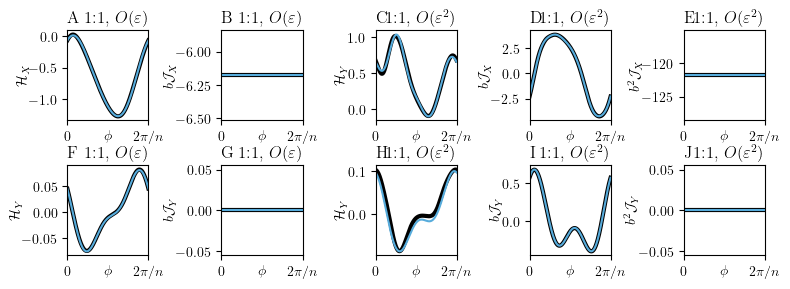

In [17]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier_vdp_thal{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 1:2

In [18]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',2),
         'NH':1000,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,20], # [eps, eps^2, etc]
        }
a12 = nm.nmCoupling(**kw_nm)

Initializing 12 Coupling...
pfactor 29
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H vdp_thal0, order=0...
* Loading H vdp_thal1, order=0...
* Loading H vdp_thal0, order=1...
* Loading H vdp_thal1, order=1...


## A

### eps

In [19]:
a = a12
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=10)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1 h1a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=10)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1 j1a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 h1a(x)= -0.6517+2*cos(x*2.0)*(0.0848)-2*sin(x*2.0)*(-0.0107)
hom osc 1 order 1 -0.6517+0.1696\cos(2x) +0.0214\sin(2x) 

het osc 1 order 1, c1 j1a(x)= -6.1799
het osc 1 order 1, c1 -6.1799


### eps^2

In [20]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=10)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2 h2a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1 j2a1(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2 j2a2(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 h2a(x)= 0.2885+2*cos(x*2.0)*(0.0879)+2*cos(x*4.0)*(0.0241)-2*sin(x*2.0)*(-0.1988)
hom osc 1 order 2 0.2885+0.1758\cos(2x) +0.0481\cos(4x) +0.3977\sin(2x) 

het osc 1 order 2, c1 j2a1(x)= 0.3413+2*cos(x*2.0)*(-0.2071)+2*cos(x*4.0)*(0.1259)+2*cos(x*8.0)*(0.0120)-2*sin(x*2.0)*(-1.0702)-2*sin(x*4.0)*(-0.0486)
het osc 1 order 2, c1 0.3413-0.4142\cos(2x) +0.2517\cos(4x) +0.0240\cos(8x) +2.1403\sin(2x) +0.0971\sin(4x) 

het osc 1 order 2, c2 j2a2(x)= -121.8605
het osc 1 order 2, c2 -121.8605


## B

### eps

In [21]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=10)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1 h1b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=10)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1 j1b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 h1b(x)= +2*cos(x*2.0)*(0.0173)-2*sin(x*2.0)*(0.0182)
hom osc 2 order 1 +0.0347\cos(2x) -0.0365\sin(2x) 

het osc 2 order 1, c1 j1b(x)= 
het osc 2 order 1, c1 


### eps^2

In [22]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=10)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2 h2b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1 j2b1(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2 j2b2(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 h2b(x)= +2*cos(x*2.0)*(0.0307)+2*cos(x*4.0)*(0.0137)
hom osc 2 order 2 +0.0614\cos(2x) +0.0275\cos(4x) 

het osc 2 order 2, c1 j2b1(x)= +2*cos(x*2.0)*(0.2120)+2*cos(x*4.0)*(0.0847)-2*sin(x*2.0)*(-0.2075)-2*sin(x*4.0)*(-0.1397)
het osc 2 order 2, c1 +0.4239\cos(2x) +0.1694\cos(4x) +0.4149\sin(2x) +0.2794\sin(4x) 

het osc 2 order 2, c2 j2b2(x)= 
het osc 2 order 2, c2 


## Plot

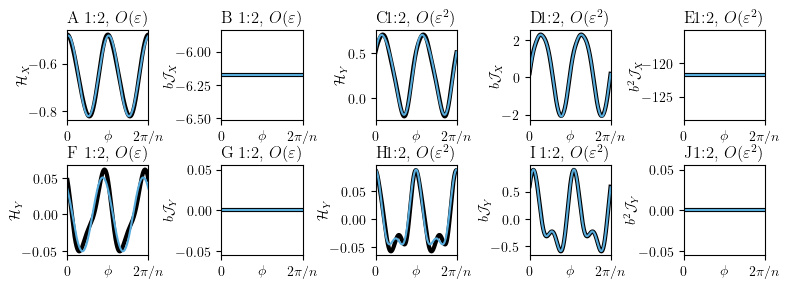

In [23]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier_vdp_thal{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 2:1

In [24]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',2),'_m':('om1',1),
         'NH':1000,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,20], # [eps, eps^2, etc]
        }
a21 = nm.nmCoupling(**kw_nm)

Initializing 21 Coupling...
pfactor 29
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H vdp_thal0, order=0...
* Loading H vdp_thal1, order=0...
* Loading H vdp_thal0, order=1...
* Loading H vdp_thal1, order=1...


## A

### eps

In [25]:
a = a21
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1 h1a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=10)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1 j1a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 h1a(x)= -0.6517+2*cos(x*2.0)*(0.0965)+2*cos(x*4.0)*(-0.0116)-2*sin(x*2.0)*(-0.0491)-2*sin(x*4.0)*(-0.0069)
hom osc 1 order 1 -0.6517+0.1930\cos(2x) -0.0231\cos(4x) +0.0983\sin(2x) +0.0138\sin(4x) 

het osc 1 order 1, c1 j1a(x)= -6.1799
het osc 1 order 1, c1 -6.1799


### eps^2

In [26]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=10)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2 h2a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1 j2a1(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2 j2a2(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 h2a(x)= 0.4208+2*cos(x*2.0)*(0.1863)+2*cos(x*4.0)*(0.0286)-2*sin(x*2.0)*(-0.1204)
hom osc 1 order 2 0.4208+0.3725\cos(2x) +0.0572\cos(4x) +0.2409\sin(2x) 

het osc 1 order 2, c1 j2a1(x)= 0.3459+2*cos(x*2.0)*(-0.3202)+2*cos(x*4.0)*(-0.0792)+2*cos(x*6.0)*(0.0144)+2*cos(x*8.0)*(0.0125)-2*sin(x*2.0)*(-0.6307)-2*sin(x*4.0)*(0.1548)-2*sin(x*6.0)*(0.0137)
het osc 1 order 2, c1 0.3459-0.6404\cos(2x) -0.1585\cos(4x) +0.0287\cos(6x) +0.0249\cos(8x) +1.2614\sin(2x) -0.3095\sin(4x) -0.0274\sin(6x) 

het osc 1 order 2, c2 j2a2(x)= -121.8370
het osc 1 order 2, c2 -121.8370


## B

### eps

In [27]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1 h1b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1 j1b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 h1b(x)= +2*cos(x*2.0)*(0.0066)-2*sin(x*2.0)*(0.0150)
hom osc 2 order 1 +0.0132\cos(2x) -0.0300\sin(2x) 

het osc 2 order 1, c1 j1b(x)= 
het osc 2 order 1, c1 


### eps^2

In [28]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2 h2b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1 j2b1(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=0)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2 j2b2(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 h2b(x)= 0.0017+2*cos(x*2.0)*(0.0068)+2*cos(x*4.0)*(-0.0011)-2*sin(x*2.0)*(-0.0025)-2*sin(x*4.0)*(-0.0025)
hom osc 2 order 2 0.0017+0.0135\cos(2x) -0.0022\cos(4x) +0.0050\sin(2x) +0.0051\sin(4x) 

het osc 2 order 2, c1 j2b1(x)= +2*cos(x*2.0)*(0.0899)-2*sin(x*2.0)*(-0.0412)
het osc 2 order 2, c1 +0.1798\cos(2x) +0.0824\sin(2x) 

het osc 2 order 2, c2 j2b2(x)= 
het osc 2 order 2, c2 


## Plot

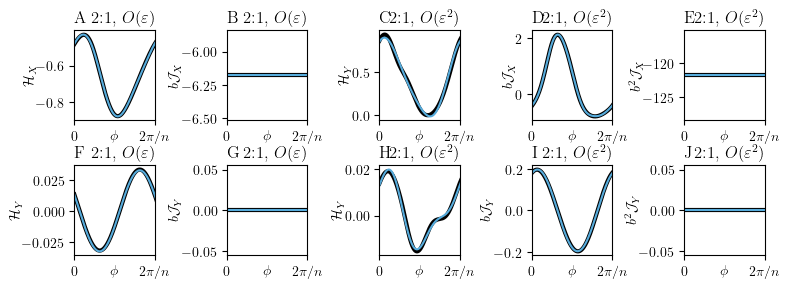

In [29]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier_vdp_thal{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 2:3

In [30]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',2),'_m':('om1',3),
         'NH':1000,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,20], # [eps, eps^2, etc]
        }
a13 = nm.nmCoupling(**kw_nm)

Initializing 23 Coupling...
pfactor 29
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H vdp_thal0, order=0...
* Loading H vdp_thal1, order=0...
* Loading H vdp_thal0, order=1...
* Loading H vdp_thal1, order=1...


## A

### eps

In [31]:
a = a13
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1 h1a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=10)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1 j1a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 h1a(x)= -0.6517+2*cos(x*6.0)*(0.0086)-2*sin(x*6.0)*(0.0080)
hom osc 1 order 1 -0.6517+0.0173\cos(6x) -0.0161\sin(6x) 

het osc 1 order 1, c1 j1a(x)= -6.1799
het osc 1 order 1, c1 -6.1799


### eps^2

In [32]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=10)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2 h2a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1 j2a1(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2 j2a2(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 h2a(x)= 0.2842+2*cos(x*6.0)*(0.0592)-2*sin(x*6.0)*(-0.0650)
hom osc 1 order 2 0.2842+0.1183\cos(6x) +0.1299\sin(6x) 

het osc 1 order 2, c1 j2a1(x)= 0.3459+2*cos(x*6.0)*(0.1366)-2*sin(x*6.0)*(-0.1571)-2*sin(x*12.0)*(-0.0156)
het osc 1 order 2, c1 0.3459+0.2733\cos(6x) +0.3142\sin(6x) +0.0312\sin(12x) 

het osc 1 order 2, c2 j2a2(x)= -121.8370
het osc 1 order 2, c2 -121.8370


## B

### eps

In [33]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1 h1b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=1)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1 j1b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 h1b(x)= +2*cos(x*6.0)*(0.0074)-2*sin(x*6.0)*(0.0057)
hom osc 2 order 1 +0.0148\cos(6x) -0.0114\sin(6x) 

het osc 2 order 1, c1 j1b(x)= 
het osc 2 order 1, c1 


### eps^2

In [34]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2 h2b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1 j2b1(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2 j2b2(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 h2b(x)= 0.0065+2*cos(x*6.0)*(0.0088)-2*sin(x*6.0)*(-0.0101)
hom osc 2 order 2 0.0065+0.0177\cos(6x) +0.0201\sin(6x) 

het osc 2 order 2, c1 j2b1(x)= +2*cos(x*6.0)*(0.1008)-2*sin(x*6.0)*(-0.1324)
het osc 2 order 2, c1 +0.2015\cos(6x) +0.2647\sin(6x) 

het osc 2 order 2, c2 j2b2(x)= 
het osc 2 order 2, c2 


## Plot

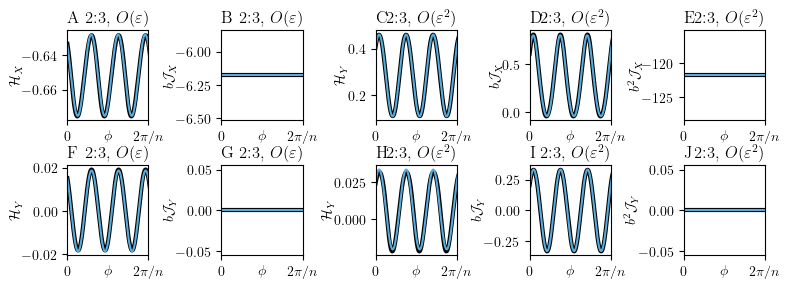

In [35]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier_vdp_thal{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 3:2

In [36]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',3),'_m':('om1',2),
         'NH':1000,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,20], # [eps, eps^2, etc]
        }
a31 = nm.nmCoupling(**kw_nm)

Initializing 32 Coupling...
pfactor 29
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H vdp_thal0, order=0...
* Loading H vdp_thal1, order=0...
* Loading H vdp_thal0, order=1...
* Loading H vdp_thal1, order=1...


## A

### eps

In [37]:
a = a31
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1 h1a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=10)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1 j1a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 h1a(x)= -0.6517+2*cos(x*6.0)*(-0.0038)-2*sin(x*6.0)*(-0.0062)
hom osc 1 order 1 -0.6517-0.0075\cos(6x) +0.0124\sin(6x) 

het osc 1 order 1, c1 j1a(x)= -6.1799
het osc 1 order 1, c1 -6.1799


### eps^2

In [38]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=10)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2 h2a(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1 j2a1(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2 j2a2(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 h2a(x)= 0.3035+2*cos(x*6.0)*(0.0206)
hom osc 1 order 2 0.3035+0.0413\cos(6x) 

het osc 1 order 2, c1 j2a1(x)= 0.3468+2*cos(x*6.0)*(-0.0765)-2*sin(x*6.0)*(0.0536)-2*sin(x*12.0)*(0.0123)
het osc 1 order 2, c1 0.3468-0.1530\cos(6x) -0.1072\sin(6x) -0.0247\sin(12x) 

het osc 1 order 2, c2 j2a2(x)= -121.8328
het osc 1 order 2, c2 -121.8328


## B

### eps

In [39]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=.1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1 h1b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=10)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1 j1b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 h1b(x)= 0.0004+2*cos(x*6.0)*(-0.0003)-2*sin(x*6.0)*(0.0002)
hom osc 2 order 1 0.0004-0.0006\cos(6x) -0.0005\sin(6x) 

het osc 2 order 1, c1 j1b(x)= 
het osc 2 order 1, c1 


### eps^2

In [40]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=.1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2 h2b(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=1)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1 j2b1(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=1)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2 j2b2(x)=',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('het osc 2 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 h2b(x)= -0.0027+2*cos(x*6.0)*(-0.0002)-2*sin(x*6.0)*(0.0010)-2*sin(x*12.0)*(0.0001)
hom osc 2 order 2 -0.0027-0.0004\cos(6x) -0.0019\sin(6x) -0.0002\sin(12x) 

het osc 2 order 2, c1 j2b1(x)= +2*cos(x*6.0)*(0.0030)-2*sin(x*6.0)*(0.0034)
het osc 2 order 2, c1 +0.0060\cos(6x) -0.0067\sin(6x) 

het osc 2 order 2, c2 j2b2(x)= 
het osc 2 order 2, c2 


## Plot

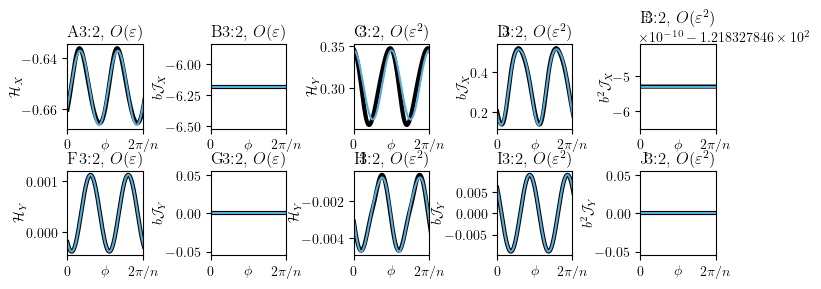

In [41]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)
    
    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier_vdp_thal{}{}.pdf'.format(a._n[1],a._m[1]))

#axs